#computer vision with pytorch

In [ ]:
import torch
from torch import nn as nn
from matplotlib import pyplot as plt
import numpy as np
import torchvision as tv
from torchvision import datasets
from torchvision.transforms import ToTensor as TT

#Getting Datasets

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=TT(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)

100%|██████████| 26421880/26421880 [00:00<00:00, 45754809.41it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5629087.06it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 21704188.81it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11989048.86it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=TT(),
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
image , label = train_data[0]
print(type(image),type(label))

<class 'torch.Tensor'> <class 'int'>


It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
It gives our neural network more chances to update its gradients per epoch.
and at a time you cant load that many images in ram

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

returns an iterable of pytorch to acccess the data


In [ ]:
print(len(train_dataloader))
print(len(test_dataloader))

1875
313


In [ ]:
# train_dataloader[0] cant be used, it's an iterable to be used in loops
#like a generator
#can't access each element at once

In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))#the batch contains 32 samples
print(f"Feature batch shape: {train_features_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")
train_features_batch.shape, train_labels_batch.shape

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

32 batch size,1 colour chanel and height and width of 28 pixel


In [ ]:
class_to_idx = train_data.class_to_idx
class_names = train_data.classes
class_to_idx, class_names

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


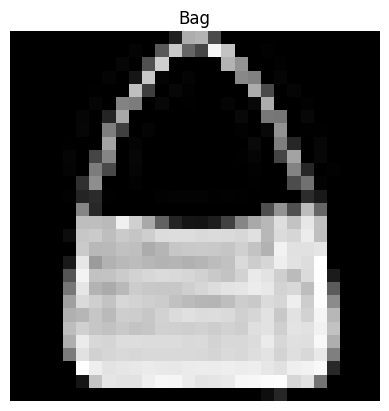

In [ ]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

flatten layer
nn.flatten

start_dim=1: The flattening operation starts from the second dimension (index 1).
end_dim=-1: The flattening operation continues up to and including the last dimension.by defaul flattens all dimensions except the batch dimension (dimension 0).

In [ ]:
x=train_features_batch[0]
print(f"before flattening:{x.shape}")
output=nn.Flatten()(x)
print(f"after flattening:{output.shape}")

before flattening:torch.Size([1, 28, 28])
after flattening:torch.Size([1, 784])


In [ ]:
hidden_units=8
class image_classifier(nn.Module):
    def __init__(self,input_shape:int,hidden_unit:int,output_shape:int):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.ReLU()
        )

    def forward(self,x):
        return self.layer_stack(x)

modelV6=image_classifier(
    input_shape=28*28,
    hidden_unit=10,
    output_shape=len(class_names))

with torch.inference_mode():
    print(modelV6(x).shape)

print(train_features_batch.shape)

torch.Size([1, 10])
torch.Size([32, 1, 28, 28])


In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=modelV6.parameters(),lr=0.01)

In [ ]:
import time

creating training loop

In [ ]:
from tqdm.auto import tqdm
start_time=time.time()
epochs=20
for epoch in tqdm(range(epochs)):
    loss=0
    accuracy=0
    for train_features_batch, train_labels_batch in train_dataloader:
        batch_time_start=time.time()

        modelV6.train()

        y_logits=modelV6(train_features_batch)

        train_loss=loss_fn(y_logits,train_labels_batch)

        loss+=train_loss

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        y_pred=torch.softmax(y_logits,dim=1)

        y_label_pred=torch.argmax(y_pred,dim=1)

        accuracy+=torch.sum(y_label_pred==train_labels_batch)/len(train_labels_batch)*100

        batch_time_end=time.time()

    avg_loss=loss/len(train_dataloader)

    avg_acc=(accuracy/len(train_dataloader))

    modelV6.eval()
    with torch.inference_mode():
        test_loss=0
        test_accuracy=0
        for test_features_batch, test_labels_batch in test_dataloader:

            test_logits=modelV6(test_features_batch)

            test_loss+=loss_fn(test_logits,test_labels_batch)

            test_pred=torch.softmax(test_logits,dim=1)

            test_label_pred=torch.argmax(test_pred,dim=1)

            test_accuracy+=torch.sum(test_label_pred==test_labels_batch)/len(test_labels_batch)*100

        avg_test_loss=test_loss/len(test_dataloader)
        avg_test_acc=test_accuracy/len(test_dataloader)


    if epoch%4==0:
        print(f"batch time:{batch_time_end-batch_time_start}")
        print(f"epoch:{epoch}|avg_train_loss:{avg_loss}|train_acc:{avg_acc}%|")
        print(f"test_loss:{avg_test_loss}|test_acc:{avg_test_acc}%")
        print()

end_time=time.time()

print(f"time taken:{end_time-start_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

batch time:0.0012259483337402344
epoch:0|avg_train_loss:1.1278403997421265|train_acc:61.53499984741211%|
test_loss:0.6718493103981018|test_acc:75.61901092529297%

batch time:0.0011756420135498047
epoch:4|avg_train_loss:0.4698670208454132|train_acc:83.65833282470703%|
test_loss:0.4917505979537964|test_acc:82.73761749267578%

batch time:0.0012865066528320312
epoch:8|avg_train_loss:0.4347323477268219|train_acc:84.92666625976562%|
test_loss:0.46831485629081726|test_acc:83.55631256103516%

batch time:0.0012857913970947266
epoch:12|avg_train_loss:0.418605238199234|train_acc:85.50499725341797%|
test_loss:0.458188533782959|test_acc:83.92572021484375%

batch time:0.0016851425170898438
epoch:16|avg_train_loss:0.40917304158210754|train_acc:85.74166870117188%|
test_loss:0.45592933893203735|test_acc:83.96565246582031%

time taken:273.9321563243866
